## Data pre-processing to conduct harmonics on ellipse data and gph anomaly data. 

In [1]:
#import statements
import datetime as dt
import numpy as np
import xarray as xr
import pickle

/knight/anaconda_jan21/envs/aug21/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
##GPH and ellipse data from within this folder
##weighted, gph at 500hPa averaged over the north atlantic region
infile = open("./data/NAO_gph500.p", 'rb') 
gph = pickle.load(infile)
infile.close()

# calculated ellipse metrics
infile = open("./data/wind10_NaN.p", 'rb') 
wind = pickle.load(infile)
infile.close()

infile = open("./data/cenlat10_NaN.p", 'rb') 
cenlat = pickle.load(infile)
infile.close()

infile = open("./data/size10_NaN.p", 'rb') 
size = pickle.load(infile)
infile.close()

infile = open("./data/ephi10_NaN.p", 'rb') 
ephi = pickle.load(infile)
infile.close()

infile = open("./data/rat10_NaN.p", 'rb') 
rat = pickle.load(infile)
infile.close()

##zonal-mean meridional eddy heat flux
infile = open("./data/CAN_zmehf.p", 'rb') 
zmehf = pickle.load(infile)
infile.close()

In [3]:
##check size of all
print(gph.shape)
print(wind.shape)
print(cenlat.shape)
print(size.shape)
print(rat.shape)
print(ephi.shape)
print(zmehf.shape)

##gph and zmehf need leap day removed

(63, 151)
(63, 151)
(63, 151)
(63, 151)
(63, 151)
(63, 151)
(63, 151)


In [9]:
##okay so i have to do this because it's somehow saving the previous shape of the heat flux lol
zm = np.zeros_like(zmehf)
zm[:,:] = zmehf[:,:]

In [4]:
## check all for NaNs
if np.any(np.isnan(gph)) or np.any(np.isinf(gph)):
    print("NaN or Inf values found in gph!")

if np.any(np.isnan(wind)) or np.any(np.isinf(wind)):
    print("NaN or Inf values found in wind!")

if np.any(np.isnan(rat)) or np.any(np.isinf(rat)):
    print("NaN or Inf values found in ratio!")

if np.any(np.isnan(ephi)) or np.any(np.isinf(ephi)):
    print("NaN or Inf values found in rotation angle!")

if np.any(np.isnan(cenlat)) or np.any(np.isinf(cenlat)):
    print("NaN or Inf values found in central latitude!")

if np.any(np.isnan(size)) or np.any(np.isinf(size)):
    print("NaN or Inf values found in size!")

if np.any(np.isnan(zmehf)) or np.any(np.isinf(zmehf)):
    print("NaN or Inf values found in heat flux!")

In [5]:
##definition statements for FFT and anomaly

def anom(data): ##as shape (63,151)
    dailymean = np.nanmean(data,axis=1)
    anomaly=np.zeros_like(data)
    for t in np.arange(data.shape[1]):
         anomaly[:,t] = data[:,t] - dailymean
    return anomaly; 

def FFT(anomaly, bott_period, top_period):
    datafil=np.zeros_like(anomaly)

    for y in np.arange(anomaly.shape[0]):
        d = anomaly[y,:] #extracts data for each year
        
        fftout=np.fft.fft(d,axis=0) #compute fast fourier over the days axis
        
        pers=d.shape[0]/np.arange(1, d.shape[0] + 1) ##calculating the period in days for frequency
        
        #Ifil=np.where(np.logical_and(pers>=14,pers<=60))[0] ##select subseasonal fluctuation
        Ifil=np.where(np.logical_and(pers>=bott_period,pers<=top_period))[0] 
        
        fftfil=np.zeros_like(fftout)
        fftfil[Ifil]=fftout[Ifil] #copy into array
        fftfil[-Ifil]=fftout[-Ifil] #conjugate symmetry
        
        datafil[y,:,]=np.fft.ifft(fftfil,axis=0).real

    return datafil; 

In [10]:
##calculate anomalies
anom_w = anom(wind)
anom_r = anom(rat)
anom_e = anom(ephi)
anom_c = anom(cenlat)
anom_s = anom(size)
anom_g = anom(gph)
anom_h = anom(zm)

In [14]:
##conduct FFT smoothing on daily anomalies, 10-50 day periods

windfil = FFT(anom_w , 10, 50) ##wind
ratfil = FFT(anom_r , 10, 50) ##ratio
ephifil = FFT(anom_e , 10, 50) ##ephi
latfil = FFT(anom_c , 10, 50) ##central latitude
sizefil = FFT(anom_s , 10, 50) ##size
gphfil = FFT(anom_g , 10, 50) ##gph
ehffil = FFT(anom_h , 10, 50) ##meridional eddy heat flux

In [15]:
import matplotlib.pyplot as plt 

In [16]:
gphfil.shape

(63, 151)

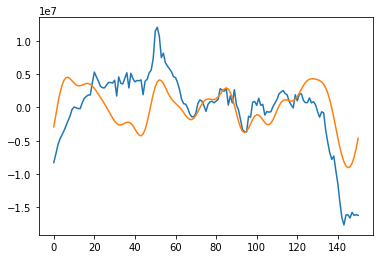

In [25]:
plt.plot(anom_s[60,:])
plt.plot(sizefil[60,:])

In [26]:
##subtract off median from gph 

In [27]:
dailymed = np.nanmedian(gphfil,axis=1)
med_g=np.zeros_like(gphfil)
for t in np.arange(gphfil.shape[1]):
     med_g[:,t] = gphfil[:,t] - dailymed
med_g.shape

(63, 151)

In [28]:
gphfil[0,120:]

array([-102.14897255, -106.55374676,  -96.83400986,  -76.2526255 ,
        -49.74055677,  -22.3517027 ,    1.97129913,   21.01686347,
         34.25515112,   42.29672385,   46.1745815 ,   46.77204373,
         44.60546889,   39.98952031,   33.43723901,   26.0448442 ,
         19.618887  ,   16.41525724,   18.53012054,   27.14447095,
         41.91198687,   60.75671054,   80.21650965,   96.27483589,
        105.43681467,  105.69650226,   97.05535937,   81.3902085 ,
         61.68952168,   40.90522841,   20.82188073])

In [29]:
med_g[0,120:]

array([-101.26488128, -105.66965549,  -95.94991859,  -75.36853423,
        -48.85646549,  -21.46761142,    2.8553904 ,   21.90095474,
         35.1392424 ,   43.18081513,   47.05867277,   47.65613501,
         45.48956017,   40.87361159,   34.32133028,   26.92893548,
         20.50297828,   17.29934851,   19.41421182,   28.02856222,
         42.79607815,   61.64080181,   81.10060092,   97.15892716,
        106.32090594,  106.58059354,   97.93945065,   82.27429977,
         62.57361295,   41.78931969,   21.705972  ])

In [30]:
###pickle out datasets
##ellipse metrics
pickle.dump(windfil, open("1121_filtered_wind.p", 'wb'))
pickle.dump(ratfil, open("1121_filtered_ratio.p", 'wb'))
pickle.dump(ephifil, open("1121_filtered_ephi.p", 'wb'))
pickle.dump(latfil, open("1121_filtered_clat.p", 'wb'))
pickle.dump(sizefil, open("1121_filtered_size.p", 'wb'))
pickle.dump(ehffil, open("1121_filtered_zmehf.p", 'wb'))

##gph
pickle.dump(gphfil, open("1121_filtered_gph.p", 'wb'))
pickle.dump(med_g, open("1121_filtered_gph_median.p", 'wb'))